In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [3]:


# input image dimensions
img_rows, img_cols = 32, 32
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


In [5]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 250

In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size = batch_size)



Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [7]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()
        
        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )
        
    
    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        
        return x

In [8]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim
        
        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )
        
        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()
        
        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
    
    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        return x
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")
        '''
        Input shape: (64, 32, 32, 3)
        conv_block1.shape: (64, 14, 14, 64)
        conv_block2.shape: (64, 5, 5, 128)
        conv_block3.shape: (64, 2, 2, 256)
        flattened shape: (64, 1024)
        Encoder output shape: (64, 100)
        '''
        
        return None

In [9]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim
        
        # self.inp_layer = InputLayer(input_shape = self.latent_dim)
        
        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.reshape = Reshape((4, 4, 256))
        
        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
       
        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )
        
        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )
        
    
    def call(self, X):
        # X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X
        
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (100))
        return Model(inputs = [x], outputs = self.call(x))
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")
        
        '''
        Input shape: (64, 100)
        first dense layer shape: (64, 100)
        second dense layer shape: (64, 1024)
        third dense layer shape: (64, 4096)
        reshape: (64, 4, 4, 256)
        conv transpose layer1 shape: (64, 8, 8, 256)
        conv transpose layer2 shape: (64, 8, 8, 256)
        conv transpose layer3 shape: (64, 16, 16, 128)
        conv transpose layer4 shape: (64, 16, 16, 128)
        conv transpose layer5 shape: (64, 32, 32, 64)
        conv transpose layer6 shape: (64, 32, 32, 64)
        Decoder output shape: (64, 32, 32, 3)
        '''
        
        return None
        

In [10]:
class Sampling(tf.keras.layers.Layer):
    """
    Create a sampling layer.
    Uses (mu, log_var) to sample latent vector 'z'.
    """
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard 
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)

In [20]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()
        
        self.latent_space = latent_space
        
        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)
        
        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)
        
    
    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)
        print(z)
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        # mu.shape: (batch_size, 100), log_var.shape: (batch_size, 100) & z.shape: (batch_size, 100)
        '''
        
        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var, z
    
    
    def model(self):
        '''
        Overrides 'model()' call.
        Output shape is not well-defined when using sub-classing. As a
        workaround, this method is implemeted.
        '''
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))

In [21]:
# Initialize VAE model-
model = VAE(latent_space = 100)

In [22]:
# Get model summary-
model.model().summary()
model.build((None, 32,32,3))

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='sampling_1/add:0', description="created by layer 'sampling_1'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv6__encoder_1 (Conv6_Encode  (None, 100)         1250996     ['input_3[0][0]']                
 r)                                                                                               
                                                                                                  
 dense_10 (Dense)               (None, 100)          10100       ['conv6__encoder_1[0][0]']       
                                       

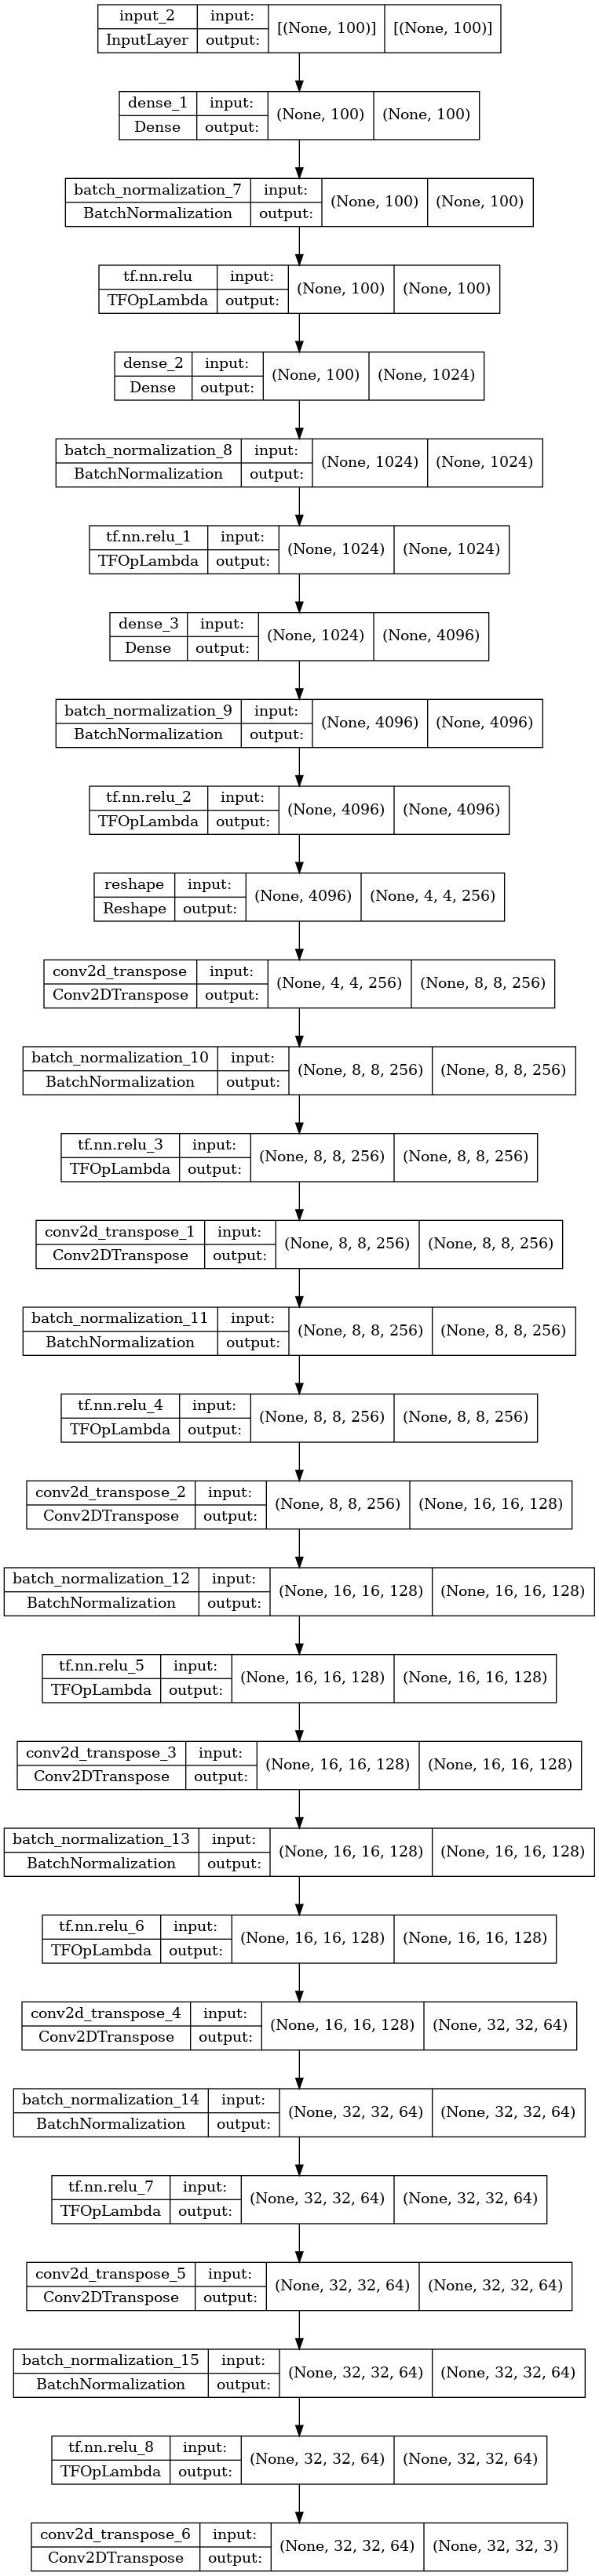

In [14]:
from tensorflow.keras.utils import plot_model 
plot_model(model.decoder.model(), show_shapes=True, to_file='vgg_vae_decoder_model.png')

In [15]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [16]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):
    
    # Reconstruction loss-
    # recon_loss = tf.keras.losses.mean_squared_error(K.flatten(data), K.flatten(reconstruction))

    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#             tf.keras.losses.mean_squared_error(data, reconstruction),
#             axis = (1, 2)
            )
        )
    
    # KL-divergence loss-    
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )

    total_loss = (recon_loss * alpha) + kl_loss
    
    return total_loss, recon_loss, kl_loss
    

In [17]:
@tf.function
def train_one_step(model, optimizer, data, alpha):
    # Function to perform one step/iteration of training

    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        data_recon, mu, log_var, z = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )
    
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(total_loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    # Apply computed gradients to model's weights and biases-
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss, recon_loss, kl_loss


@tf.function
def test_step(model, optimizer, data, alpha):
    '''
    Function to test model performance
    on testing dataset
    '''
    # Make predictions using defined model-
    data_recon, mu, log_var, z = model(data)
    
    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )
    
    return total_loss, recon_loss, kl_loss

In [18]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [19]:
for epoch in range(1, num_epochs + 1):
    """
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    """

    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0
    
    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )
        
        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()
    
    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)
        
        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()
    
    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }
    
    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

epoch = 1; total train loss = 5175180.8438, train recon loss = 515316.7307, train kl loss = 22013.5317; total val loss = 1007047.9951, val recon loss = 99975.9307 & val kl loss = 7288.6837
epoch = 2; total train loss = 4953253.4092, train recon loss = 490984.0656, train kl loss = 43412.7446; total val loss = 989195.4395, val recon loss = 97997.0944 & val kl loss = 9224.4994
epoch = 3; total train loss = 4906749.4341, train recon loss = 485997.8008, train kl loss = 46771.4213; total val loss = 982605.5000, val recon loss = 97272.6026 & val kl loss = 9879.4741
epoch = 4; total train loss = 4869957.4858, train recon loss = 481888.5884, train kl loss = 51071.5986; total val loss = 974700.8296, val recon loss = 96353.5036 & val kl loss = 11165.7954
epoch = 5; total train loss = 4831768.8716, train recon loss = 477709.6466, train kl loss = 54672.4086; total val loss = 972118.9492, val recon loss = 96126.0613 & val kl loss = 10858.3349
epoch = 6; total train loss = 4813273.1880, train recon l

epoch = 45; total train loss = 4647414.3999, train recon loss = 459205.7077, train kl loss = 55357.3170; total val loss = 938056.9390, val recon loss = 92693.1447 & val kl loss = 11125.4936
epoch = 46; total train loss = 4646590.5684, train recon loss = 459117.6204, train kl loss = 55414.3791; total val loss = 937743.6255, val recon loss = 92662.2466 & val kl loss = 11121.1566
epoch = 47; total train loss = 4645379.8706, train recon loss = 458992.5238, train kl loss = 55454.6260; total val loss = 938511.8457, val recon loss = 92755.3348 & val kl loss = 10958.5000
epoch = 48; total train loss = 4644104.6665, train recon loss = 458854.6324, train kl loss = 55558.3470; total val loss = 938032.0508, val recon loss = 92674.6049 & val kl loss = 11286.0007
epoch = 49; total train loss = 4642459.7661, train recon loss = 458681.5325, train kl loss = 55644.4395; total val loss = 937775.7642, val recon loss = 92652.6689 & val kl loss = 11249.0789
epoch = 50; total train loss = 4641510.8286, train

epoch = 89; total train loss = 4606904.9751, train recon loss = 454957.6514, train kl loss = 57328.4478; total val loss = 938959.6333, val recon loss = 92760.2913 & val kl loss = 11356.7208
epoch = 90; total train loss = 4606138.4790, train recon loss = 454873.4590, train kl loss = 57403.8910; total val loss = 939000.6323, val recon loss = 92760.1637 & val kl loss = 11399.0022
epoch = 91; total train loss = 4605942.3438, train recon loss = 454847.5585, train kl loss = 57466.7545; total val loss = 938843.8813, val recon loss = 92737.2932 & val kl loss = 11470.9506
epoch = 92; total train loss = 4604705.0356, train recon loss = 454721.4053, train kl loss = 57490.9826; total val loss = 939843.2915, val recon loss = 92836.7772 & val kl loss = 11475.5225
epoch = 93; total train loss = 4604202.2412, train recon loss = 454665.4180, train kl loss = 57548.0675; total val loss = 939109.2002, val recon loss = 92759.2921 & val kl loss = 11516.2759
epoch = 94; total train loss = 4603893.7861, train

epoch = 132; total train loss = 4586696.4478, train recon loss = 452752.7142, train kl loss = 59169.3141; total val loss = 941112.4653, val recon loss = 92920.3388 & val kl loss = 11909.0768
epoch = 133; total train loss = 4586467.4023, train recon loss = 452718.9467, train kl loss = 59277.9297; total val loss = 941273.5127, val recon loss = 92934.7405 & val kl loss = 11926.1059
epoch = 134; total train loss = 4586542.0786, train recon loss = 452732.0640, train kl loss = 59221.4415; total val loss = 941594.2739, val recon loss = 92979.9095 & val kl loss = 11795.1850
epoch = 135; total train loss = 4586040.4419, train recon loss = 452677.6974, train kl loss = 59263.4636; total val loss = 940787.0654, val recon loss = 92910.8805 & val kl loss = 11678.2626
epoch = 136; total train loss = 4585543.1455, train recon loss = 452622.0286, train kl loss = 59322.8636; total val loss = 941848.7808, val recon loss = 92992.4158 & val kl loss = 11924.6263
epoch = 137; total train loss = 4585213.5005,

epoch = 175; total train loss = 4575493.9302, train recon loss = 451526.1874, train kl loss = 60232.0587; total val loss = 943790.7871, val recon loss = 93146.9960 & val kl loss = 12320.8282
epoch = 176; total train loss = 4575828.6255, train recon loss = 451556.4971, train kl loss = 60263.6548; total val loss = 943539.9966, val recon loss = 93163.3796 & val kl loss = 11906.2002
epoch = 177; total train loss = 4575540.6553, train recon loss = 451527.1422, train kl loss = 60269.2367; total val loss = 942678.9399, val recon loss = 93071.2614 & val kl loss = 11966.3248
epoch = 178; total train loss = 4574924.9146, train recon loss = 451466.7424, train kl loss = 60257.4884; total val loss = 943949.9575, val recon loss = 93176.6658 & val kl loss = 12183.2954
epoch = 179; total train loss = 4574788.7148, train recon loss = 451449.9115, train kl loss = 60289.5928; total val loss = 944063.6499, val recon loss = 93188.2979 & val kl loss = 12180.6694
epoch = 180; total train loss = 4574790.2749,

KeyboardInterrupt: 

In [ ]:
import graphviz

In [ ]:
# model.save('vgg_based_250')

In [ ]:
X_train.shape

In [ ]:
x_data = X_test[:2000]
y_data = y_test[:2000]

In [ ]:
# mu_np = model.mu.numpy()
# sigm_np = model.log_var.numpy()

# mu_np = np.mean(mu_np)
# sigm_np1 = np.mean(np.exp(sigm_np))
# sigm_np2 = np.exp(np.mean(sigm_np))

# %matplotlib inline
# z_ex = np.random.normal(mu_np, sigm_np1, 100)
# X_hat = tf.keras.activations.sigmoid(model.decoder(z_ex.reshape(1, 100)))
# plt.imshow(X_hat[0], cmap='gray')

In [ ]:
%matplotlib inline
j = 10
lat = model.encoder(x_data[j].reshape(1,32,32,3))
plt.imshow(x_data[j])

In [ ]:
mu = model.mu(lat)
var = model.log_var(lat)
z = Sampling()(mu, var)
x_hat = tf.keras.activations.sigmoid(model.decoder(z))
plt.imshow(x_hat[0])

In [ ]:
data_recon, mu, log_var, z = model(x_data)

In [ ]:
%matplotlib inline
i=50
plt.imshow(data_recon[i])

In [ ]:
plt.imshow(x_data[i])

In [ ]:
# z_gen = np.random.normal(0, 1, 100)
# z_gen.shape
mu = tf.random.normal([100], 0, 1, tf.float32)
sigma = tf.random.normal([100], 0, 1, tf.float32)
z_gen = model.reparameterize(mu, sigma)
X_hat = tf.keras.activations.sigmoid(model.decoder(z_gen.numpy().reshape(1, 100)))
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(2)
plt.imshow(X_hat[0])


In [ ]:
# 0 airplane 1 car 2 bird 3 cat 4 deer 5 dog 6 frog 7 horse 8 ship 9 truck